## 03 - Feature Engineering
German Credit Risk Dataset

**Hedef Metrik:** Kredi riski asimetrik bir problemdir. Riskli bir müşteriyi kaçırmak (False Negative), iyi bir müşteriyi reddetmekten (False Positive) çok daha maliyetlidir. Bu nedenle **Recall (bad sınıfı)** öncelikli metriğimizdir. Model seçiminde **ROC-AUC**, threshold ayarında ise **F1-score** kullanılır.

### Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.base import clone

import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

sns.set_theme(style='whitegrid')
COLORS = {'good': '#4a90a4', 'bad': '#e07b54'}
RANDOM_STATE = 42

### Load Data & Split

In [2]:
df = pd.read_csv('../data/german_credit_data.csv', index_col=0)

job_mapping = {0: 'unskilled_non_resident', 1: 'unskilled_resident', 2: 'skilled', 3: 'highly_skilled'}
df['Job'] = df['Job'].map(job_mapping)

X = df.drop('Risk', axis=1)
y = df['Risk'].map({'good': 0, 'bad': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (800, 9), Test: (200, 9)


### Feature Engineering

Mevcut değişkenlerden, kredi riski açısından anlamlı yeni değişkenler türetiyoruz:

| Değişken | Formül | Açıklama | Neden Önemli? |
|----------|--------|----------|---------------|
| **credit_per_month** | `Credit amount / Duration` | Müşterinin her ay ödemesi gereken tahmini kredi tutarı | Aylık ödeme yükü doğrudan geri ödeme kapasitesiyle ilişkilidir. Yüksek aylık taksit, temerrüt riskini artırır. |
| **credit_to_age** | `Credit amount / Age` | Müşterinin yaşına oranla aldığı kredi büyüklüğü | Genç müşterilerin gelir seviyesi genellikle daha düşüktür. Yaşına göre orantısız yüksek kredi alan bireyler daha risklidir. |
| **saving_score** | Kategorik -> Sayısal (0-4) | Tasarruf hesabı seviyesinin sayısal karşılığı (0=hesap yok/bilinmiyor, 1=little, 2=moderate, 3=quite rich, 4=rich) | Tasarruf düzeyi, mali güvenlik ağının bir göstergesidir. Tasarrufu yüksek müşteriler kriz anında ödemelerini sürdürebilir. |
| **checking_score** | Kategorik -> Sayısal (0-3) | Vadesiz hesap seviyesinin sayısal karşılığı (0=hesap yok/bilinmiyor, 1=little, 2=moderate, 3=rich) | Vadesiz hesap bakiyesi, günlük nakit akışının göstergesidir. Düşük bakiye, gelir-gider dengesizliğine işaret edebilir. |

**Not:** `saving_score` ve `checking_score` için eksik değerler (NaN) 0 olarak kodlanır. Bu, hesap bilgisi bilinmeyen müşterileri en düşük seviyeye atar, çünkü bilgi eksikliği genellikle düşük finansal erişimle ilişkilidir.

In [3]:
def engineer_features(df):
    df = df.copy()
    df['credit_per_month'] = df['Credit amount'] / df['Duration'].replace(0, 1)
    df['credit_to_age'] = df['Credit amount'] / df['Age']
    
    saving_map = {'little': 1, 'moderate': 2, 'quite rich': 3, 'rich': 4}
    checking_map = {'little': 1, 'moderate': 2, 'rich': 3}
    df['saving_score'] = df['Saving accounts'].map(saving_map).fillna(0)
    df['checking_score'] = df['Checking account'].map(checking_map).fillna(0)
    
    return df

X_train_fe = engineer_features(X_train)
X_test_fe = engineer_features(X_test)

base_num = ['Age', 'Credit amount', 'Duration']
new_features = ['credit_per_month', 'credit_to_age', 'saving_score', 'checking_score']
cat_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

print(f"New features: {new_features}")

New features: ['credit_per_month', 'credit_to_age', 'saving_score', 'checking_score']


### Feature Selection Per Model

In [4]:
def build_pipeline(num_cols, cat_cols, model):
    preprocessor = ColumnTransformer([
        ('num', Pipeline([('imp', SimpleImputer(strategy='median')), ('scl', StandardScaler())]), num_cols),
        ('cat', Pipeline([('imp', SimpleImputer(strategy='constant', fill_value='missing')), ('enc', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), cat_cols)
    ])
    return Pipeline([('prep', preprocessor), ('clf', model)])

def get_cv_auc(pipe, X_tr, y_tr, cv=5):
    scores = cross_val_score(pipe, X_tr, y_tr, cv=cv, scoring='roc_auc')
    return scores.mean()

In [5]:
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE, verbosity=0, n_jobs=-1),
    'LightGBM': LGBMClassifier(random_state=RANDOM_STATE, verbose=-1, n_jobs=-1),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)
}

selection_results = {}

for name, model in models.items():
    print(f"{name}: ", end='')
    
    # Use CV on train set only (no data leak)
    baseline_pipe = build_pipeline(base_num, cat_features, clone(model))
    baseline_auc = get_cv_auc(baseline_pipe, X_train_fe, y_train)
    
    selected_features = []
    current_auc = baseline_auc
    
    for feat in new_features:
        test_num = base_num + selected_features + [feat]
        test_pipe = build_pipeline(test_num, cat_features, clone(model))
        test_auc = get_cv_auc(test_pipe, X_train_fe, y_train)
        
        if test_auc > current_auc:
            selected_features.append(feat)
            current_auc = test_auc
    
    selection_results[name] = {
        'baseline_cv_auc': baseline_auc,
        'final_cv_auc': current_auc,
        'selected_features': selected_features
    }
    
    print(f"CV-AUC {baseline_auc:.4f} -> {current_auc:.4f} | Features: {selected_features if selected_features else 'None'}")

Logistic Regression: CV-AUC 0.7481 -> 0.7483 | Features: ['credit_to_age', 'saving_score']
Random Forest: CV-AUC 0.7260 -> 0.7363 | Features: ['credit_per_month']
XGBoost: CV-AUC 0.7202 -> 0.7372 | Features: ['credit_per_month', 'checking_score']
LightGBM: CV-AUC 0.7299 -> 0.7407 | Features: ['credit_per_month']
CatBoost: CV-AUC 0.7430 -> 0.7557 | Features: ['credit_per_month']


### Train & Evaluate on Test Set

In [6]:
results = {}
predictions = {}
probabilities = {}
pipelines = {}

for name, model in models.items():
    selected = selection_results[name]['selected_features']
    num_cols = base_num + selected
    
    pipe = build_pipeline(num_cols, cat_features, clone(model))
    pipe.fit(X_train_fe, y_train)
    
    y_pred = pipe.predict(X_test_fe)
    y_prob = pipe.predict_proba(X_test_fe)[:, 1]
    
    results[name] = {'Accuracy': accuracy_score(y_test, y_pred), 'ROC-AUC': roc_auc_score(y_test, y_prob)}
    predictions[name] = y_pred
    probabilities[name] = y_prob
    pipelines[name] = pipe

results_df = pd.DataFrame(results).T.round(4).sort_values('ROC-AUC', ascending=False)
results_df

,Accuracy,ROC-AUC
CatBoost,0.735,0.7799
Logistic Regression,0.735,0.7624
Random Forest,0.745,0.7580
XGBoost,0.735,0.7250
LightGBM,0.725,0.7195


In [7]:
# Select top 2 models for hyperparameter tuning
top_2_models = results_df.head(2).index.tolist()
print(f"Top 2 models for hyperparameter tuning: {top_2_models}")

Top 2 models for hyperparameter tuning: ['CatBoost', 'Logistic Regression']


### Hyperparameter Tuning (Optuna)

In [8]:
def get_preprocessor(num_cols):
    return ColumnTransformer([
        ('num', Pipeline([('imp', SimpleImputer(strategy='median')), ('scl', StandardScaler())]), num_cols),
        ('cat', Pipeline([('imp', SimpleImputer(strategy='constant', fill_value='missing')), ('enc', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), cat_features)
    ])

In [9]:
# CatBoost Optuna objective
def catboost_objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_state': RANDOM_STATE,
        'verbose': False
    }
    
    num_cols = base_num + selection_results['CatBoost']['selected_features']
    model = CatBoostClassifier(**params)
    pipe = Pipeline([('prep', get_preprocessor(num_cols)), ('clf', model)])
    
    scores = cross_val_score(pipe, X_train_fe, y_train, cv=5, scoring='roc_auc')
    return scores.mean()

# LightGBM Optuna objective
def lgbm_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 15, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'random_state': RANDOM_STATE,
        'verbose': -1,
        'n_jobs': -1
    }
    
    num_cols = base_num + selection_results['LightGBM']['selected_features']
    model = LGBMClassifier(**params)
    pipe = Pipeline([('prep', get_preprocessor(num_cols)), ('clf', model)])
    
    scores = cross_val_score(pipe, X_train_fe, y_train, cv=5, scoring='roc_auc')
    return scores.mean()

In [10]:
N_TRIALS = 100

print("Tuning CatBoost...")
#catboost_study = optuna.create_study(direction='maximize')
#catboost_study.optimize(catboost_objective, n_trials=N_TRIALS, show_progress_bar=True)

#print(f"\nBest CatBoost params: {catboost_study.best_params}")
#print(f"Best CV AUC: {catboost_study.best_value:.4f}")

Tuning CatBoost...


In [11]:
print("Tuning LightGBM...")
lgbm_study = optuna.create_study(direction='maximize')
lgbm_study.optimize(lgbm_objective, n_trials=N_TRIALS, show_progress_bar=True)

print(f"\nBest LightGBM params: {lgbm_study.best_params}")
print(f"Best CV AUC: {lgbm_study.best_value:.4f}")

Tuning LightGBM...


  0%|          | 0/100 [00:00<?, ?it/s]


Best LightGBM params: {'n_estimators': 444, 'max_depth': 8, 'learning_rate': 0.26773734589698106, 'num_leaves': 19, 'min_child_samples': 48, 'reg_alpha': 8.010743670941924, 'reg_lambda': 6.9190754799983285}
Best CV AUC: 0.7608


In [14]:
# Train tuned models
tuned_results = {}
tuned_probabilities = {}
tuned_predictions = {}

# CatBoost tuned
#catboost_tuned = CatBoostClassifier(**catboost_study.best_params, random_state=RANDOM_STATE, verbose=False)
#num_cols_cb = base_num + selection_results['CatBoost']['selected_features']
#pipe_cb = Pipeline([('prep', get_preprocessor(num_cols_cb)), ('clf', catboost_tuned)])
#pipe_cb.fit(X_train_fe, y_train)
#y_prob_cb = pipe_cb.predict_proba(X_test_fe)[:, 1]
#y_pred_cb = pipe_cb.predict(X_test_fe)
#tuned_results['CatBoost'] = roc_auc_score(y_test, y_prob_cb)
#tuned_probabilities['CatBoost'] = y_prob_cb
#tuned_predictions['CatBoost'] = y_pred_cb

# LightGBM tuned
lgbm_tuned = LGBMClassifier(**lgbm_study.best_params, random_state=RANDOM_STATE, verbose=-1, n_jobs=-1)
num_cols_lgbm = base_num + selection_results['LightGBM']['selected_features']
pipe_lgbm = Pipeline([('prep', get_preprocessor(num_cols_lgbm)), ('clf', lgbm_tuned)])
pipe_lgbm.fit(X_train_fe, y_train)
y_prob_lgbm = pipe_lgbm.predict_proba(X_test_fe)[:, 1]
y_pred_lgbm = pipe_lgbm.predict(X_test_fe)
tuned_results['LightGBM'] = roc_auc_score(y_test, y_prob_lgbm)
tuned_probabilities['LightGBM'] = y_prob_lgbm
tuned_predictions['LightGBM'] = y_pred_lgbm

print("Tuned vs Default (Test Set):")
#for name in ['CatBoost', 'LightGBM']:
    #default = results[name]['ROC-AUC']
    #tuned = tuned_results[name]
    #print(f"  {name}: Default {default:.4f} -> Tuned {tuned:.4f} ({tuned - default:+.4f})")

Tuned vs Default (Test Set):


### Model Inspection

In [15]:
# Select best tuned model
SELECTED_MODEL = max(tuned_results, key=tuned_results.get)

print(f"Best Tuned Model: {SELECTED_MODEL}")
print(f"ROC-AUC: {tuned_results[SELECTED_MODEL]:.4f}")
print(f"\n{'='*50}")
print("Classification Report (threshold=0.5):")
print(classification_report(y_test, tuned_predictions[SELECTED_MODEL], target_names=['good', 'bad']))

Best Tuned Model: LightGBM
ROC-AUC: 0.7651

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

        good       0.78      0.87      0.82       140
         bad       0.59      0.43      0.50        60

    accuracy                           0.74       200
   macro avg       0.69      0.65      0.66       200
weighted avg       0.72      0.74      0.73       200



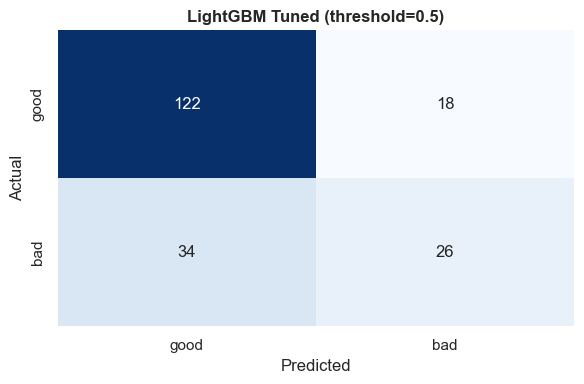

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
cm = confusion_matrix(y_test, tuned_predictions[SELECTED_MODEL])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
            xticklabels=['good', 'bad'], yticklabels=['good', 'bad'])
ax.set_title(f'{SELECTED_MODEL} Tuned (threshold=0.5)', fontweight='bold')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

### Threshold Optimization

Varsayılan threshold (0.5) her iki sınıfa eşit davranır. Threshold düşürüldüğünde model daha fazla **bad** tahmin eder. Bu **Recall'ı artırır** (riskli müşteriler daha iyi yakalanır) ancak **Precision düşer** (yanlış alarm artar). Amaç, iş ihtiyacına göre bu dengeyi en iyi kuran threshold değerini bulmaktır.

In [17]:
SELECTED_MODEL = 'LightGBM'

print(f"Threshold Optimization for: {SELECTED_MODEL}")
print(f"ROC-AUC: {tuned_results[SELECTED_MODEL]:.4f}")
print('='*50)

y_prob = tuned_probabilities[SELECTED_MODEL]
thresholds = np.arange(0.1, 0.9, 0.05)

threshold_results = []
for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    threshold_results.append({
        'Threshold': thresh,
        'Accuracy': accuracy_score(y_test, y_pred_thresh),
        'Precision (bad)': precision_score(y_test, y_pred_thresh),
        'Recall (bad)': recall_score(y_test, y_pred_thresh),
        'F1 (bad)': f1_score(y_test, y_pred_thresh)
    })

thresh_df = pd.DataFrame(threshold_results).round(4)
thresh_df

Threshold Optimization for: LightGBM
ROC-AUC: 0.7651


,Threshold,Accuracy,Precision (bad),Recall (bad),F1 (bad)
0,0.10,0.400,0.3295,0.9667,0.4915
1,0.15,0.550,0.3929,0.9167,0.5500
2,0.20,0.630,0.4407,0.8667,0.5843
3,0.25,0.650,0.4500,0.7500,0.5625
4,0.30,0.700,0.5000,0.7167,0.5890
5,0.35,0.720,0.5278,0.6333,0.5758
6,0.40,0.720,0.5345,0.5167,0.5254
7,0.45,0.730,0.5625,0.4500,0.5000
8,0.50,0.740,0.5909,0.4333,0.5000
9,0.55,0.735,0.5946,0.3667,0.4536


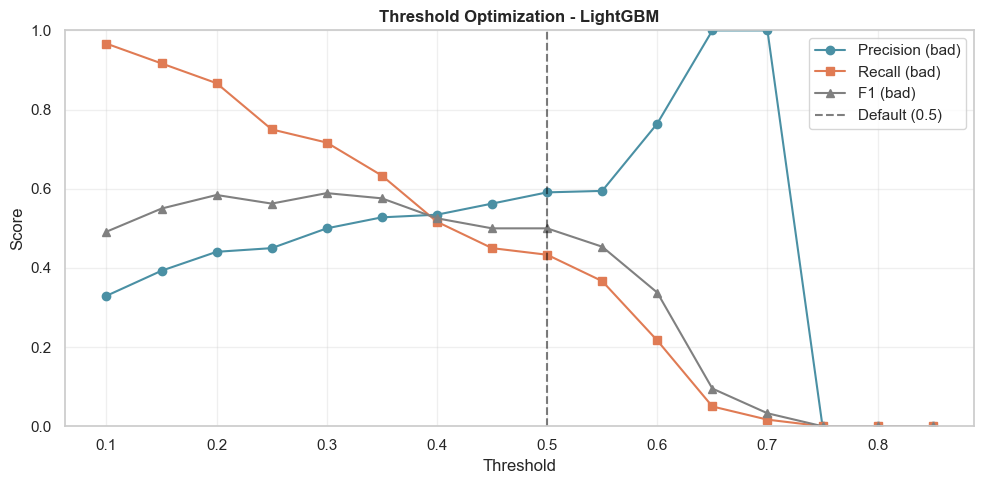

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(thresh_df['Threshold'], thresh_df['Precision (bad)'], 'o-', label='Precision (bad)', color=COLORS['good'])
ax.plot(thresh_df['Threshold'], thresh_df['Recall (bad)'], 's-', label='Recall (bad)', color=COLORS['bad'])
ax.plot(thresh_df['Threshold'], thresh_df['F1 (bad)'], '^-', label='F1 (bad)', color='gray')
ax.axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Default (0.5)')

ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title(f'Threshold Optimization - {SELECTED_MODEL}', fontweight='bold')
ax.legend()
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
# Set threshold manually (or use auto: thresh_df['F1 (bad)'].idxmax())
MANUAL_THRESHOLD = 0.30

optimal_threshold = MANUAL_THRESHOLD
closest_idx = (thresh_df['Threshold'] - optimal_threshold).abs().idxmin()

print(f"Selected threshold: {optimal_threshold:.2f}")
print(f"\nMetrics at this threshold:")
print(thresh_df.loc[closest_idx])

Selected threshold: 0.30

Metrics at this threshold:
Threshold          0.3000
Accuracy           0.7000
Precision (bad)    0.5000
Recall (bad)       0.7167
F1 (bad)           0.5890
Name: 4, dtype: float64


In [23]:
y_pred_default = tuned_predictions[SELECTED_MODEL]
y_pred_optimized = (y_prob >= optimal_threshold).astype(int)

print("Comparison:")
print(f"\nDefault (threshold=0.5):")
print(f"  Bad Recall: {recall_score(y_test, y_pred_default):.2%}")
print(f"  Bad Precision: {precision_score(y_test, y_pred_default):.2%}")
print(f"  Bad F1: {f1_score(y_test, y_pred_default):.2%}")

print(f"\nOptimized (threshold={optimal_threshold:.2f}):")
print(f"  Bad Recall: {recall_score(y_test, y_pred_optimized):.2%}")
print(f"  Bad Precision: {precision_score(y_test, y_pred_optimized):.2%}")
print(f"  Bad F1: {f1_score(y_test, y_pred_optimized):.2%}")

Comparison:

Default (threshold=0.5):
  Bad Recall: 43.33%
  Bad Precision: 59.09%
  Bad F1: 50.00%

Optimized (threshold=0.30):
  Bad Recall: 71.67%
  Bad Precision: 50.00%
  Bad F1: 58.90%


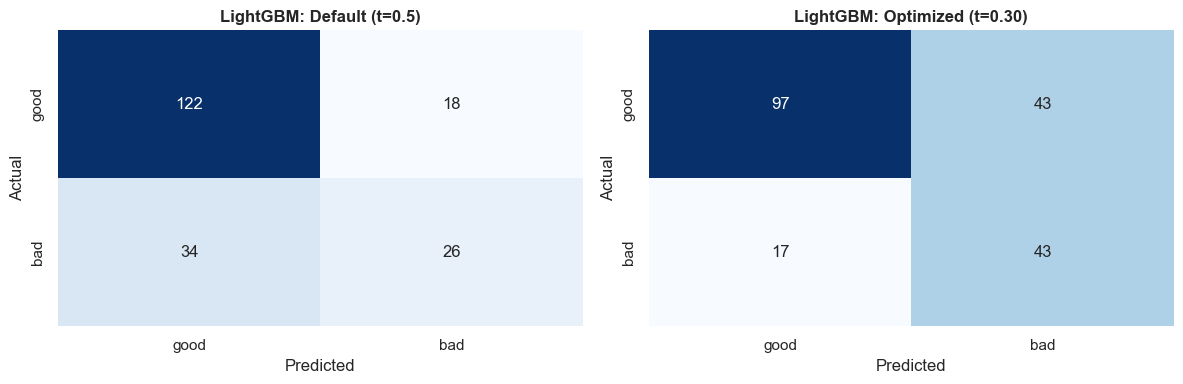

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, (y_pred, title) in zip(axes, [(y_pred_default, 'Default (t=0.5)'), (y_pred_optimized, f'Optimized (t={optimal_threshold:.2f})')]):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                xticklabels=['good', 'bad'], yticklabels=['good', 'bad'])
    ax.set_title(f'{SELECTED_MODEL}: {title}', fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

### Save Tuned Model

Seçilen modelin tune edilmiş pipeline'ını diske kaydediyoruz. Pipeline preprocessor ve model adımlarını birlikte içerdiği için, yüklendikten sonra doğrudan tahmin yapılabilir.

In [26]:
import pickle
import os

# Select the tuned pipeline based on SELECTED_MODEL
tuned_pipes = {'LightGBM': pipe_lgbm}
final_pipeline = tuned_pipes[SELECTED_MODEL]

# Save
models_dir = os.path.join('..', 'models')
os.makedirs(models_dir, exist_ok=True)

model_filename = f'{SELECTED_MODEL.lower()}_tuned_pipeline.pkl'
model_path = os.path.join(models_dir, model_filename)

with open(model_path, 'wb') as f:
    pickle.dump(final_pipeline, f)
print(f"Model saved: {model_path}")
print(f"  Model: {SELECTED_MODEL}")
print(f"  ROC-AUC: {tuned_results[SELECTED_MODEL]:.4f}")
print(f"  Optimal Threshold: {optimal_threshold:.2f}")

Model saved: ..\models\lightgbm_tuned_pipeline.pkl
  Model: LightGBM
  ROC-AUC: 0.7651
  Optimal Threshold: 0.30
